In [1]:
import numpy as np
#from lvmdrp.core.rss import RSS, loadRSS
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.io import ascii
#from astropy.table import Table
import matplotlib.colors as mcolors
c = c = list(mcolors.XKCD_COLORS.values())

from astropy.stats import sigma_clip

from scipy.optimize import least_squares

def vacuum_to_air(lambda_vac):
    """
    Vacuum-to-air wavelength conversion

    Args:
        lambda_vac: vacuum wavelength in Angstrom

    Returns:
        lambda_air: air wavelength in Angstrom

    Donald Morton (2000, ApJ. Suppl., 130, 403)
    """

    s = 1e4 / lambda_vac
    n = 1 + 0.0000834254 + 0.02406147 / (130 - s ** 2) + 0.00015998 / (38.9 - s ** 2)
    lambda_air = lambda_vac / n
    return lambda_air

def air_to_vacuum(lambda_air):
    """
    Air-to-vacuum wavelength conversion

    Args:
        lambda_air: air wavelength in Angstrom

    Returns:
        lambda_vac: vacuum wavelength in Angstrom
    """

    s = 1e4 / lambda_air
    n = 1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 - s**2) + 0.0001599740894897 / \
        (38.92568793293 - s**2)
    lambda_vac = lambda_air * n
    return lambda_vac

data = ascii.read("lvm_sky_lines_all.dat", format='basic')


In [2]:
data.colnames

['wave',
 'flux_lvm',
 'flux_eso',
 'trans',
 'type',
 'electronic_state',
 'rotational_upper_level']

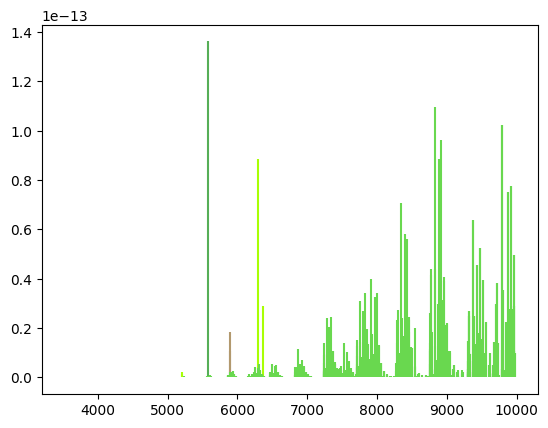

In [3]:
sys = data['type']
for i in range(np.min(sys), np.max(sys)):
    m = sys==i
    plt.vlines(data['wave'][m], np.zeros_like(data['wave'])[m], data['flux_lvm'][m], colors=c[i])


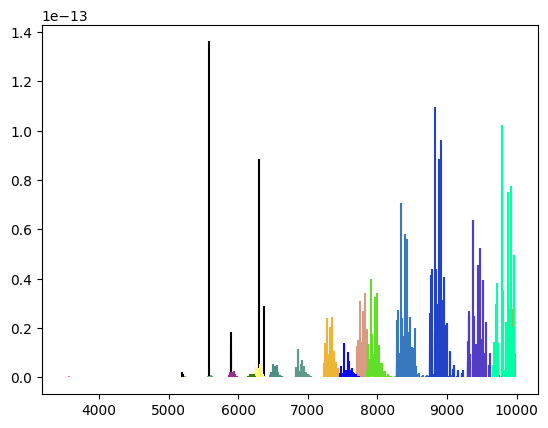

In [3]:
sys = data['electronic_state']
m = sys==-999
plt.vlines(data['wave'][m], np.zeros_like(data['wave'])[m], data['flux_lvm'][m], colors='k')
for i in range(0, np.max(sys)):
    m = sys==i
    plt.vlines(data['wave'][m], np.zeros_like(data['wave'])[m], data['flux_lvm'][m], colors=c[i])


In [4]:
def polynomial_fit_with_outliers(wave, flux, degree=3, sigma_lower=3, sigma_upper=3, grow=0, max_iter=10):
    """
    Perform a polynomial fit to the total spectrum while iteratively removing outliers.

    Parameters:
        wave, flux: input spectrum
        degree (int): Degree of the polynomial fit.
        sigma_lower (float): Lower sigma value for sigma-clipping to identify outliers.
        sigma_upper (float): Upper sigma value for sigma-clipping to identify outliers.
        grow (int): Number of pixels to grow the mask of clipped values.
        max_iter (int): Maximum number of iterations for outlier removal.

    Returns:
        fitted flux, mask
    """

    # Initial fit
    coefficients = np.polyfit(wave, flux, degree)
    fitted_flux = np.polyval(coefficients, wave)

    # Iterate until convergence or max_iter
    for _ in range(max_iter):
        # Compute residuals
        residuals = flux - fitted_flux

        # Perform sigma clipping
        mask = sigma_clip(residuals, sigma_lower=sigma_lower, sigma_upper=sigma_upper, grow=grow).mask

        # Update masked spectrum table
        masked_wave = wave[~mask]
        masked_flux = flux[~mask]

        # Perform polynomial fit
        coefficients = np.polyfit(masked_wave, masked_flux, degree)

        # Evaluate polynomial fit on the wavelength grid
        fitted_flux = np.polyval(coefficients, wave)

    return fitted_flux, mask

def line_group_residuals(x, w, f):
    return line_group(x,w) - f

def line_group(x, w):
    y = np.zeros_like(w)
    for i in range(0, len(x), 2):
        amp = x[i]
        ctr = x[i+1]
        # sig = x[i+2]
        sig = 1.5
        y = y + amp * np.exp( -((w - ctr)/sig)**2)
    return y

def fit_line_group(lines_w, lines_f, w, f):
    guess = []
    for i in range(len(lines_w)):
        guess += [lines_f[i], lines_w[i]]
    res = least_squares(line_group_residuals, guess, args = (w, f))

    return res

def get_lines_and_continuum(spec=2234):
    with fits.open('XCframe_1.1.1_3469_31300_1.fits') as hdu:
        wc = hdu['WAVE'].data
        sc = hdu['FLUX'].data[spec,]
        # subtract continuum
        cont, _ = polynomial_fit_with_outliers(wc, sc, degree=3, sigma_lower=2, sigma_upper=3)
        lines_only = sc - cont
        #hdu.info()
        return wc, sc, cont, lines_only

# fig = plt.figure(figsize=(12,4))
# sys = data['electronic_state']
# for i in range(0, np.max(sys)):
#     m = sys==i
#     if not any(m):
#         continue
#     flux = data['flux_lvm'][m]
#     # wave = vacuum_to_air(data['wave'][m])
#     wave = data['wave'][m]
#     #plt.vlines(wave, np.zeros_like(data['Wavelength'])[m], flux, colors=c[i])
#     #plt.plot(wc, lines_only, linewidth=1, color='k')
#     res = fit_line_group(wave, flux, wc, lines_only)
#     fit = line_group(res.x, wc)
#     plt.plot(wc, fit+cont, linewidth=2, color=c[i])


# plt.plot(wc,sc,'k-',linewidth=1)
# plt.plot(wc,cont,'r-',linewidth=1)
# plt.semilogy()
# plt.ylim(3e-15,1e-12)



Integrate calculation of the Sky Model

In [44]:
from SkyCalcObs import write_obs_inputs, just_run_SkyCalc_from_observation, reformat2LVM
from SkyModelObs import convert_time
from GetSolar import get_flux

def get_skymodel(record, telescope='sci'):
    """
    Get the sky model for a given record in DRP-like file.
    
    This is based on the Knox Long code https://github.com/kslong/lvm_ksl/blob/main/SkyCalcObs.py
    """

    default = '''
    {
        "ra": 121.75,
        "dec": -29.7,
        "date": "2012-07-17T21:12:14",
        "observatory": "lasilla"
    }
    '''

    time_converted = convert_time(record['obstime'], 'iso_ms')

    skymodel_file = 'test_skycalc'
    skymodel_file_fits = skymodel_file + '.fits'

    if telescope == 'sci':
        ra = record['sci_ra']
        dec = record['sci_dec']
    else:
        NotImplementedError("Only 'sci' telescope is implemented.")

    write_obs_inputs(xdefault=default, ra=ra, dec=dec, xtime=time_converted, msol=-1, outroot=skymodel_file)

    _ = just_run_SkyCalc_from_observation(skymodel_file, almanac='', msol=-1, print_output=False)

    reformat2LVM(skymodel_file_fits)

    return fits.getdata(skymodel_file_fits)

/var/folders/sg/qfk9vd6n17g0pvf1kt22r13r0000gn/T/ipykernel_62110/248451053.py:34: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(masked_wave, masked_flux, degree)


(12401, 31) (12401,) (31,)


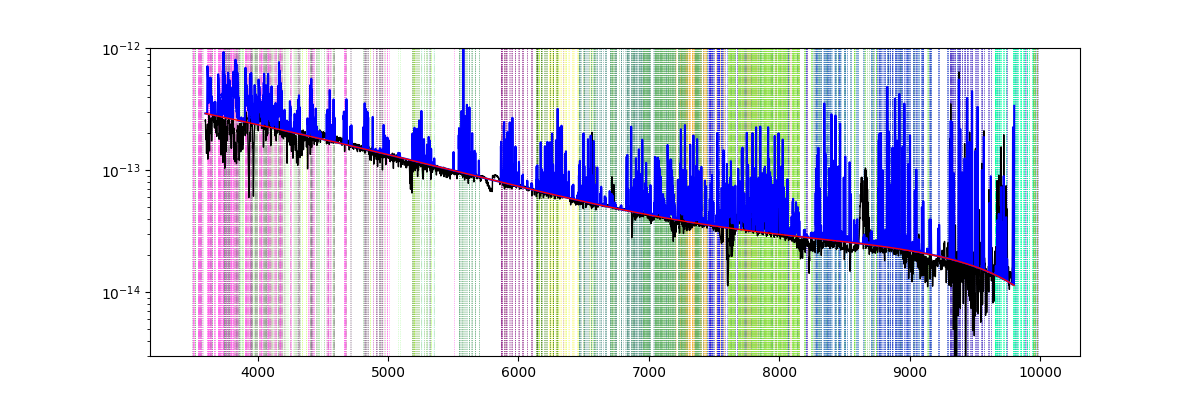

In [70]:
from scipy import sparse
%matplotlib inline

def fit_line_groups(wc, sc, cont, lines_only, plot=True):
    fact = np.sqrt(2.0 * np.pi)
    sigma = 1.5/2.35
    kernel_width = 5 # in pix, should exceed 4 sigma
    vI = []
    vJ = []
    vV = []

    sys = data['electronic_state'] # fix groups for type!=4,5
    typ = data['type']
    sys[sys==-999] = typ[sys==-999]

    ngroup = 0
    for i in range(0, np.max(sys)):
        m = sys==i
        if not any(m):
            continue
        ngroup += 1
        flux = data['flux_eso'][m]
        # wave = vacuum_to_air(data['wave'][m])
        wave = data['wave'][m]
        for line in range(len(wave)):
            if(wave[line]>wc[0] and wave[line] < wc[-1]):
                pix = np.where(wc<wave[line])[0][-1]
                for yy in range(pix-kernel_width,pix+kernel_width+1):
                    yy = np.clip(yy,0,len(wc)-1)
                    v = np.exp(-0.5 * ((wc[yy]-wave[line]) / sigma) ** 2) / (fact * sigma)
                    if v>=0.00001:   # make non-zero and positive definite
                        vI.append(ngroup)
                        vJ.append(yy)
                        vV.append(flux[line]*v / 1.0) #self._error[yy])

    B = sparse.csc_matrix((vV, (vJ, vI)), shape=(len(wc), ngroup+1))

    # plt.imshow(B.toarray(),aspect=0.002,vmin=0,vmax=1e-16)
    # plt.show()

    guess_flux = np.ones(ngroup+1) * 1e-13
    print(B.shape, lines_only.shape, guess_flux.shape)
    # out = sparse.linalg.lsmr(B, lines_only / 1.0, x0=guess_flux)
    out = sparse.linalg.lsmr(B, sc / 1.0, x0=guess_flux)

    # error = np.sqrt(1 / ((B.multiply(B)).sum(axis=0))).A
    # error = error[0,:]
    F = out[0]
    # print(ngroup, F)
    model = B.dot(F)

    if plot:
        fig = plt.figure(figsize=(12,4))
        for i in range(0, np.max(sys)):
            m = sys==i
            plt.vlines(data['wave'][m], np.zeros_like(data['wave'])[m], data['flux_eso'][m], colors=c[i], linestyles=':', linewidth=0.5)
        plt.plot(wc,sc,'k-',linewidth=1)
        plt.semilogy()
        plt.ylim(3e-15,1e-12)
        plt.plot(wc,model+cont,'b-')
        plt.plot(wc,cont,'r-',linewidth=1)

    return F, model


%matplotlib widget
wc, sc, cont, lines_only = get_lines_and_continuum(spec=3115)



F, model = fit_line_groups(wc, sc, cont, lines_only, plot=True)

---
## Model with Continuum Sky Model components

This requires install of Sky Calc Cli:

```bash
pip install skycalc_cli
```

In [161]:
tbl = Table.read('XCframe_1.1.1_3469_31300_1.fits', 'DRP_ALL')
wave = fits.getdata('XCframe_1.1.1_3469_31300_1.fits', 'WAVE')
flux = fits.getdata('XCframe_1.1.1_3469_31300_1.fits', 'FLUX')

# idx = 3115
idx = 2345
skymodel = get_skymodel(tbl[idx])

(12401, 34) (12401,) (34,)
30 [1.         2.09595442 0.87491097 4.48273124 1.0150865  0.86459347
 1.44595324 1.40267277 1.6259281  2.41097838 2.22645027 0.99532737
 2.20087717 2.30873783 2.3880063  2.12096613 1.84222427 0.64911322
 2.56990534 1.9341946  1.79879058 1.61986672 1.8250976  1.
 0.547431   1.91233868 0.95129656 0.84341065 1.01157692 1.25414797
 2.25283727 0.755076   0.45923766 2.35375697]


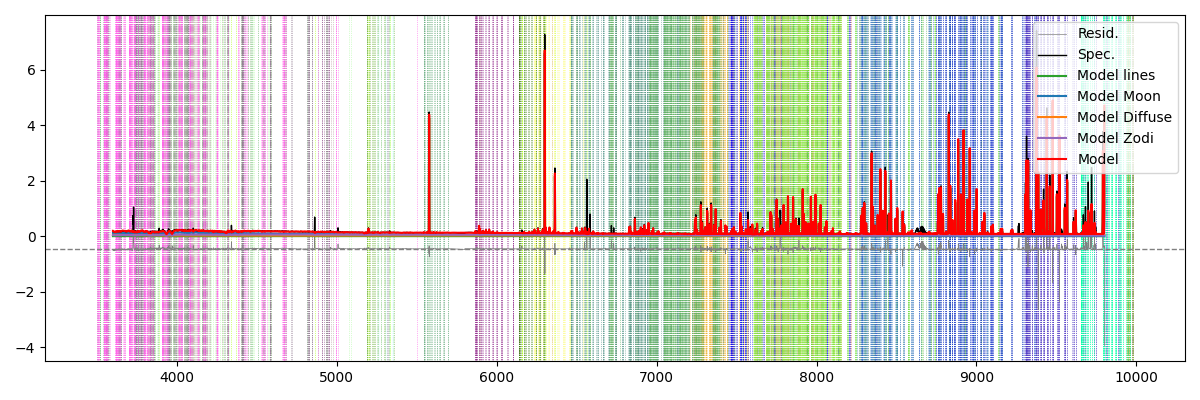

In [165]:
from scipy import sparse
%matplotlib inline

def fit_line_groups_with_continuum(wc, sc, cont, skymodel, plot=True, factor=1e-13):
    sc = sc / factor
    cont = cont/ factor

    fact = np.sqrt(2.0 * np.pi)
    sigma = 1.6/2.35
    kernel_width = 5 # in pix, should exceed 4 sigma
    vI = []
    vJ = []
    vV = []

    sys = data['electronic_state'] # fix groups for type!=4,5
    typ = data['type']
    sys[sys==-999] = typ[sys==-999]

    ngroup = 0
    for i in range(0, np.max(sys)):
        m = sys==i
        if not any(m):
            continue
        ngroup += 1
        flux = data['flux_eso'][m]
        # wave = vacuum_to_air(data['wave'][m])
        wave = data['wave'][m]
        for line in range(len(wave)):
            if(wave[line]>wc[0] and wave[line] < wc[-1]):
                pix = np.where(wc<wave[line])[0][-1]
                for yy in range(pix-kernel_width,pix+kernel_width+1):
                    yy = np.clip(yy,0,len(wc)-1)
                    v = np.exp(-0.5 * ((wc[yy]-wave[line]) / sigma) ** 2) / (fact * sigma)
                    if v>=0.00001:   # make non-zero and positive definite
                        vI.append(ngroup)
                        vJ.append(yy)
                        vV.append(flux[line]*v / 1.0) #self._error[yy])

    B = sparse.csc_matrix((vV, (vJ, vI)), shape=(len(wc), ngroup+1))

    # Add Sky Model components
    moon = skymodel['MOON'] / factor
    diffuse = skymodel['DIFFUSE'] / factor
    zodi = skymodel['ZODI'] / factor

    B = sparse.hstack([B,
                       np.reshape(moon, (moon.size, 1)),
                       np.reshape(diffuse, (diffuse.size, 1)),
                       np.reshape(zodi, (zodi.size, 1))
                       ])

    # plt.imshow(B.toarray(),aspect=0.002,vmin=0,vmax=1e-16)
    # plt.show()
    
    n_cont_components = 3

    guess_flux = np.ones(ngroup + 1 + n_cont_components)
    print(B.shape, lines_only.shape, guess_flux.shape)
    out = sparse.linalg.lsmr(B, sc, x0=guess_flux)

    # error = np.sqrt(1 / ((B.multiply(B)).sum(axis=0))).A
    # error = error[0,:]
    coefficients = out[0]
    print(ngroup, coefficients)

    B_csr = B.tocsr()
    model_lines = B_csr[:, :-n_cont_components-1].dot(coefficients[:-n_cont_components-1])
    model_moon = B_csr[:, -n_cont_components] * coefficients[-n_cont_components]
    model_diffuse = B_csr[:, -n_cont_components+1] * coefficients[-n_cont_components+1]
    model_zodi = B_csr[:, -n_cont_components+2] * coefficients[-n_cont_components+2]

    model_moon = np.ravel( model_moon.toarray() )
    model_diffuse = np.ravel( model_diffuse.toarray() )
    model_zodi = np.ravel( model_zodi.toarray() )

    model_cont = model_moon + model_diffuse + model_zodi

    model = model_lines + model_cont

    resid = sc - model
    rms = np.nanstd(resid)
    resid_level = -5 * rms


    if plot:
        fig = plt.figure(figsize=(12,4))
        for i in range(0, np.max(sys)):
            m = sys==i
            for line in data['wave'][m]:
                plt.axvline(line, color=c[i], linestyle=':', linewidth=0.5)
            # print(data['wave'][m], data['flux_eso'][m])
            # plt.vlines(data['wave'][m], colors=c[i], linestyles=':', linewidth=0.5)
            # plt.axvline(data['wave'][m], color=c[i], linestyle=':', linewidth=0.5)

        plt.plot(wc, resid_level + resid, label='Resid.', lw=0.5, color='gray')
        plt.axhline(resid_level, color='gray', linestyle='--', lw=1)
        plt.plot(wc, sc, 'k-', linewidth=1, label='Spec.')
        # plt.semilogy()
        # plt.ylim(3e-15,1e-12)
        
        plt.plot(wc, model_lines, color='C2', label='Model lines')
        plt.plot(wc, model_moon, color='C0', label='Model Moon')
        plt.plot(wc, model_diffuse, color='C1', label='Model Diffuse')
        plt.plot(wc, model_zodi, color='C4', label='Model Zodi')
        plt.plot(wc, model, color='red', label='Model')
        plt.legend()
        plt.tight_layout()

    return coefficients, model

%matplotlib widget

plt.close()
wc, sc, cont, lines_only = get_lines_and_continuum(spec=idx)
F, model = fit_line_groups_with_continuum(wc, sc, cont, skymodel, plot=True)

In [56]:
skymodel.columns

ColDefs(
    name = 'WAVE'; format = 'D'
    name = 'FLUX'; format = 'D'
    name = 'dflux1'; format = 'D'
    name = 'dflux2'; format = 'D'
    name = 'trans'; format = 'D'
    name = 'dtrans1'; format = 'D'
    name = 'dtrans2'; format = 'D'
    name = 'MOON'; format = 'D'
    name = 'flux_ssl'; format = 'D'
    name = 'ZODI'; format = 'D'
    name = 'flux_tie'; format = 'D'
    name = 'flux_tme'; format = 'D'
    name = 'LINES'; format = 'D'
    name = 'DIFFUSE'; format = 'D'
    name = 'trans_ma'; format = 'D'
    name = 'trans_o3'; format = 'D'
    name = 'trans_rs'; format = 'D'
    name = 'trans_ms'; format = 'D'
    name = 'CONT'; format = 'D'
)